In [1]:

#https://www.tensorflow.org/tutorials/images/classification?hl=pt-br
import matplotlib.pyplot as plt
import numpy as np
import os
#import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')#conectar com o drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Definir o diretório que contém as imagens de treino
data_dir = pathlib.Path('/content/drive/MyDrive/Modelo para classificacao de imagem/dataset/train')

#Verificar se o diretório existe e é válido
if data_dir.exists() and data_dir.is_dir():
    print("O diretório existe e é válido.")

    #Listar arquivos e contar imagens com diferentes extensões
    all_files = list(data_dir.rglob('*'))
    print(f"Número total de arquivos encontrados: {len(all_files)}")

    #Contar imagens com extensões jpg, jpeg e png
    image_count = sum(1 for file in all_files if file.suffix.lower() in ['.jpg', '.jpeg', '.png'])
    print(f"Total de imagens (jpg, jpeg, png): {image_count}")
else:
    print("O diretório não existe ou não é um diretório válido.")


O diretório existe e é válido.
Número total de arquivos encontrados: 251
Total de imagens (jpg, jpeg, png): 247


In [4]:
#Configurações do dataset
batch_size = 32 #Ajustar conforme necessário #32 imagens por lote
img_height = 193
img_width = 184

#Carregar o dataset de treinamento
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 247 files belonging to 2 classes.


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,#20% dos dados para validação
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 247 files belonging to 2 classes.
Using 198 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,#20% dos dados para validação
  subset="validation",
  seed=123,#obter resultados consistentes e reproduzíveis
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 247 files belonging to 2 classes.
Using 49 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['edif', 'not_edif']


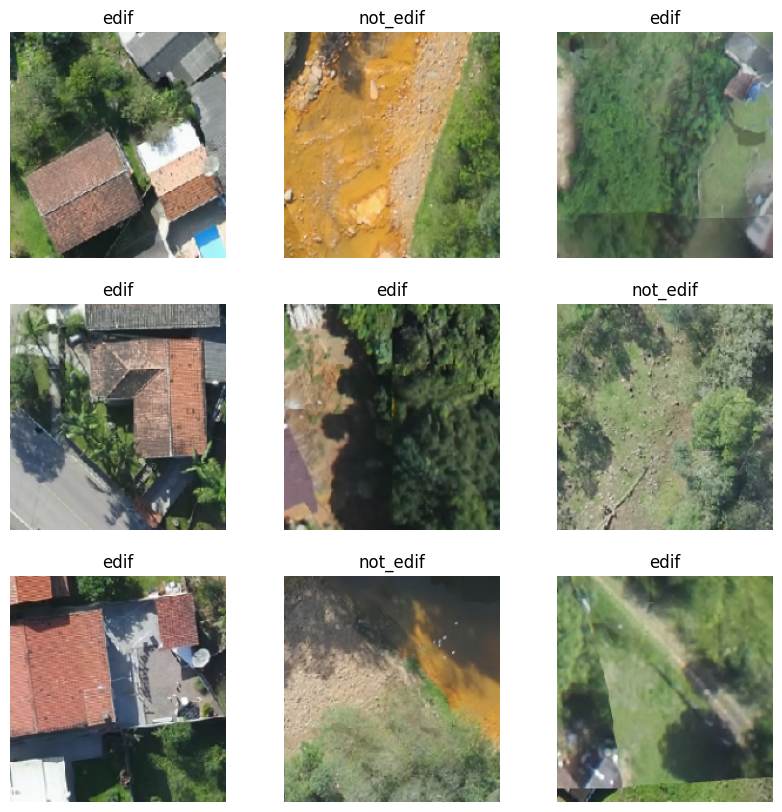

In [8]:
#plotanto as imagens edif=imagem com alguma edificação/construção e not_pivot=imagem sem edificação/construção
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
#iteração sobre o dataset train_ds para acessar e imprimir as dimensões dos dados de um lote específico.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 193, 184, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#otimizar o pipeline de dados para treinamento e validação

In [11]:
normalization_layer = layers.Rescaling(1./255)# normalization_layer escala os valores dos pixels das imagens para o intervalo 0, 1

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))#x representa as imagens e y representa os rótulos (labels).
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))#Exibe o valor mínimo e máximo dos pixels da primeira imagem após a normalização.

0.01750527 1.0


In [14]:
#criar o modelo

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #padding='same' garante que a saída da camada convolucional tenha a mesma largura e altura que a entrada
  #Exemplo:
  #16 representa o numero de filtros ou núcleos (kernels) que a camada convolucional usará
  #o valor 3 representa o tamanho do filtro (filtro 3 x3 pixels)
  #com input_shape=(img_height, img_width, 3) eu ensino a rede o formato dos dados de entrada
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
   #a camada MaxPooling2D diminuir o tamanho dos mapas de ativação e ajudar o modelo a aprender
  #representações mais abstratas e invariantes, enquanto controla o overfitting e
  #melhora a eficiência computacional.
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),#relu = algoritmo ativador (Rectified Linear Unit) 128 neurônios
  layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
#compilar o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()#resumo do modelo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 193, 184, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 193, 184, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 92, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 92, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 35328)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,522,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,545,954 (17.34 MB)

 Trainable params: 4,545,954 (17.34 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#treinando o modelo
epochs=80 #passagens completas através de todo o conjunto de dados de treinamento durante o processo de treinamento do modelo.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4013 - loss: 0.8016 - val_accuracy: 0.4082 - val_loss: 0.7137
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5236 - loss: 0.6758 - val_accuracy: 0.5918 - val_loss: 0.5902
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5898 - loss: 0.5460 - val_accuracy: 0.8571 - val_loss: 0.3984
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9506 - loss: 0.3089 - val_accuracy: 0.7755 - val_loss: 0.4974
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8709 - loss: 0.2986 - val_accuracy: 0.8776 - val_loss: 0.2616
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9446 - loss: 0.1822 - val_accuracy: 0.7755 - val_loss: 0.5884
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9317 - loss: 0.1609 - val_accuracy: 0.7959 - val_loss: 0.3696
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9530 - loss: 0.1055 - val_accuracy: 0.9184 - val_loss: 0.1981
Epoch 9/80
7

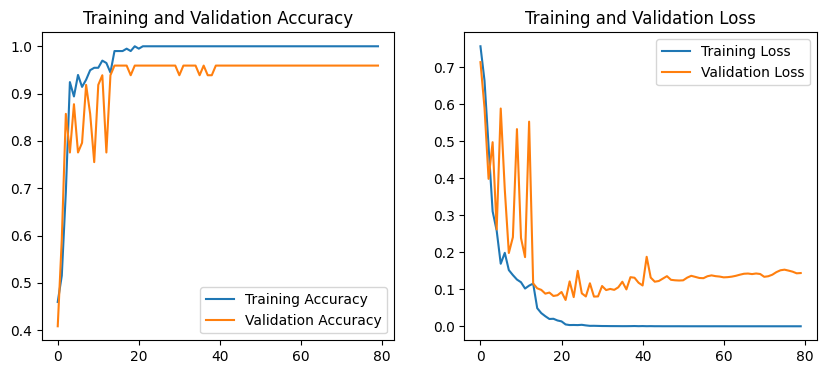

In [17]:
#visualizar os dados de treinamento com graficos de perda e precisão nos conjuntos de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#meu modelo precisa ser melhorado, pois esta ocorrendo overfitting

In [18]:
# Salvar o modelo completo em um arquivo
model.save('/content/drive/MyDrive/Modelo para classificacao de imagem.h5')

In [19]:
#imagem individual
teste = "/content/drive/MyDrive/Modelo para classificacao de imagem/dataset/teste_model/teste/img1-1_500 (0_0).png"  #imagem teste

#Carregar a imagem
img = tf.keras.utils.load_img(teste, target_size=(img_height, img_width))

#Converter a imagem para um array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  #Cria um batch

#Fazer a predição
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

#Exibir o resultado
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
This image most likely belongs to edif with a 73.11 percent confidence.


In [20]:
#imagens do diretorio
#Diretório contendo as imagens de teste
test_dir = "/content/drive/MyDrive/Modelo para classificacao de imagem/dataset/teste_model/teste"

#Listar todos os arquivos de imagem no diretório
image_files = [f for f in os.listdir(test_dir) if f.endswith('.png')]

#arquivos estão em ordem
image_files.sort()

#nomes das classes
class_names = ['not_edif', 'edif']

#Iterar sobre todos os arquivos de imagem
for image_file in image_files:
    #Caminho completo para a imagem
    image_path = os.path.join(test_dir, image_file)

    #Carregar a imagem
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))

    #Converter a imagem para um array
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    #Fazer a predição
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    #Exibir o resultado
    print(
        "{}: This image most likely belongs to '{}' with a {:.2f} percent confidence."
        .format(image_file, class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
img1-1_500 (0_0).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
img1-1_500 (0_1).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
img1-1_500 (0_2).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
img1-1_500 (0_3).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
img1-1_500 (0_4).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
img1-1_500 (0_5).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
img1-1_500 (1_0).png: This image most likely belongs to 'not_edif' with a 73.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s